In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append(r'D:\Hacks\re_new')

In [2]:
from src.utils import load_config, load_data, comp_score
from src.utils import cat_cols
from src.engine import get_model

config = load_config()
random_seed = config['RAND']

In [3]:
train_data, test_data = load_data()
train_data.shape, test_data.shape

((909604, 16), (303202, 15))

In [4]:
train_data.columns, test_data.columns

(Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
        'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
        'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
        'reactice_power_calculated_by_converter', 'reactive_power',
        'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
        'turbine_id', 'Target'],
       dtype='object'),
 Index(['timestamp', 'active_power_calculated_by_converter', 'active_power_raw',
        'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
        'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
        'reactice_power_calculated_by_converter', 'reactive_power',
        'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
        'turbine_id'],
       dtype='object'))

# Ft. Eng.

## Date time ft.eng

In [17]:
df = pd.concat([train_data, test_data], axis=0)
df.shape

(1212806, 16)

In [48]:
train_date = pd.to_datetime(train_data['timestamp'])
test_date = pd.to_datetime(test_data['timestamp'])

date = pd.to_datetime(df.timestamp)
date

0        2021-02-19 20:18:00
1        2021-04-27 04:55:00
2        2021-01-25 06:26:00
3        2021-10-30 03:47:00
4        2021-03-15 00:39:00
                 ...        
303197   2021-06-15 20:14:00
303198   2021-04-17 20:23:00
303199   2021-10-16 09:14:00
303200   2021-12-11 18:55:00
303201   2021-01-16 22:50:00
Name: timestamp, Length: 1212806, dtype: datetime64[ns]

In [32]:
date.describe()

count                 1212806
unique                 449408
top       2021-04-02 21:49:00
freq                       12
first     2021-01-01 00:01:00
last      2021-12-31 23:59:00
Name: timestamp, dtype: object

In [49]:
train_date.shape[0]/df.shape[0]

0.7499995877329103

In [43]:
date.sort_values()

45421    2021-01-01 00:01:00
658721   2021-01-01 00:02:00
545675   2021-01-01 00:03:00
772206   2021-01-01 00:04:00
245502   2021-01-01 00:06:00
                 ...        
554025   2021-12-31 23:58:00
83942    2021-12-31 23:58:00
668082   2021-12-31 23:58:00
214355   2021-12-31 23:58:00
545409   2021-12-31 23:59:00
Name: timestamp, Length: 1212806, dtype: datetime64[ns]

In [55]:
date.sort_values().diff()

45421                NaT
658721   0 days 00:01:00
545675   0 days 00:01:00
772206   0 days 00:01:00
245502   0 days 00:02:00
               ...      
554025   0 days 00:01:00
83942    0 days 00:00:00
668082   0 days 00:00:00
214355   0 days 00:00:00
545409   0 days 00:01:00
Name: timestamp, Length: 1212806, dtype: timedelta64[ns]

In [47]:
date.sort_values().diff().value_counts()   # almost 10 Lakh samples can be predicted accurtely (differ by 0 or 1 minute)

0 days 00:00:00    763398
0 days 00:01:00    416902
0 days 00:02:00     27597
0 days 00:03:00      3047
0 days 00:04:00       717
                    ...  
0 days 02:23:00         1
0 days 01:04:00         1
0 days 00:51:00         1
0 days 01:35:00         1
0 days 01:26:00         1
Name: timestamp, Length: 165, dtype: int64

In [56]:
train_date.sort_values().diff().value_counts()

0 days 00:00:00    494912
0 days 00:01:00    356948
0 days 00:02:00     46790
0 days 00:03:00      7659
0 days 00:04:00      1640
                    ...  
0 days 02:34:00         1
0 days 02:02:00         1
0 days 02:41:00         1
0 days 02:46:00         1
0 days 02:21:00         1
Name: timestamp, Length: 163, dtype: int64

In [57]:
test_date.sort_values().diff().value_counts()

0 days 00:01:00    108749
0 days 00:00:00     76289
0 days 00:02:00     55826
0 days 00:03:00     28657
0 days 00:04:00     15047
                    ...  
0 days 01:30:00         1
0 days 01:54:00         1
0 days 02:37:00         1
0 days 00:57:00         1
0 days 01:03:00         1
Name: timestamp, Length: 177, dtype: int64

In [41]:
date.dt.month.value_counts()

6     111619
8     111477
7     110915
12    104384
11    102232
3     100340
5      99499
4      97488
9      96444
10     95925
1      95504
2      86979
Name: timestamp, dtype: int64

In [28]:
print(date.dt.minute.nunique())
print(date.dt.minute.describe())

60
count    1.212806e+06
mean     2.948927e+01
std      1.749053e+01
min      0.000000e+00
25%      1.400000e+01
50%      2.900000e+01
75%      4.500000e+01
max      5.900000e+01
Name: timestamp, dtype: float64


In [23]:
date.dt.second.value_counts()  # has no info at all

0    1212806
Name: timestamp, dtype: int64

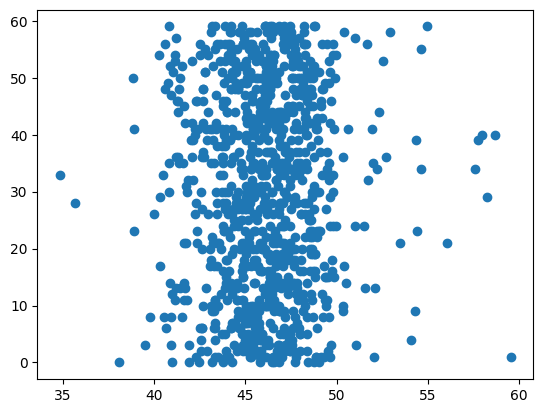

In [65]:
train_date_sample = train_date[:1000]
train_data_sample = train_data[:1000]

plt.scatter( train_data_sample.Target, train_date_sample.dt.minute);

In [66]:
dfs = df.sort_values(by='timestamp')
dfs

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
45421,2021-01-01 00:01:00,828.392253,847.524780,23.749945,1164.353088,56.914901,833.398712,23.851615,23.613581,138.066790,166.923848,228.054690,8.184143,0.535525,Turbine_108,43.430870
658721,2021-01-01 00:02:00,734.902262,751.122874,19.137422,1119.673584,55.196616,809.185425,27.618101,25.004128,124.705297,153.301956,43.115978,6.780914,0.600904,Turbine_120,40.715544
545675,2021-01-01 00:03:00,748.204336,767.003316,19.113608,1128.340881,55.682657,804.593099,27.610003,25.033796,122.845019,157.638268,43.992285,6.605300,0.533855,Turbine_120,40.706413
772206,2021-01-01 00:04:00,1115.585986,1143.363770,18.536383,1200.487305,62.660133,1161.573462,25.932306,24.076670,192.730591,224.663141,72.256642,8.286794,0.523392,Turbine_139,40.769313
245502,2021-01-01 00:06:00,975.188029,1005.913961,25.460711,1200.243095,57.926095,1018.267802,26.737586,23.928331,158.431951,196.259565,50.205800,7.899686,0.339865,Turbine_158,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554025,2021-12-31 23:58:00,635.630473,647.702566,9.400681,973.038859,49.969453,625.765503,30.920345,26.883738,106.336980,139.864756,123.650436,6.972114,0.578641,Turbine_103,42.614979
83942,2021-12-31 23:58:00,951.135590,977.182892,8.780563,1197.069234,58.330886,902.190328,20.349027,21.095316,157.545405,194.551659,78.606181,7.534583,0.606685,Turbine_105,43.700722
668082,2021-12-31 23:58:00,858.007161,885.301178,31.106428,1178.025533,59.719817,807.887004,30.799557,27.352941,146.320142,172.715530,212.963961,7.155286,0.445924,Turbine_20,43.792723
214355,2021-12-31 23:58:00,908.267832,933.286235,18.620179,1198.289958,57.573762,779.126373,30.178709,25.337340,137.384988,180.152397,69.111694,7.281371,0.530622,Turbine_13,43.219498


In [67]:
dfs.Target.isna().sum()

303202

In [73]:
df['timestamp'] = pd.to_datetime(df.timestamp)
df['month'] = df.timestamp.dt.month
df['hour'] = df.timestamp.dt.hour
df['dayofweek'] = df.timestamp.dt.dayofweek
df['dayofmonth'] = df.timestamp.dt.day
df

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target,month,hour,dayofweek,dayofmonth
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787,2,20,4,19
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328,4,4,1,27
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236,1,6,0,25
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587,10,3,5,30
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095,3,0,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303197,2021-06-15 20:14:00,1754.986613,1797.301392,39.138250,1201.708130,85.610317,1631.455973,38.890467,38.542006,341.591410,404.388580,322.968750,10.402939,1.133143,Turbine_10,NaN,6,20,1,15
303198,2021-04-17 20:23:00,961.416738,970.462962,33.718848,1194.447693,72.564436,979.040192,33.418560,33.190632,158.035688,186.806035,309.976791,7.312443,0.829828,Turbine_97,NaN,4,20,5,17
303199,2021-10-16 09:14:00,5.583539,18.309381,29.148418,771.026876,62.844919,114.049692,29.836640,31.198618,56.898274,62.813501,330.593165,3.404537,0.622060,Turbine_120,NaN,10,9,5,16
303200,2021-12-11 18:55:00,34.711766,26.472111,31.942072,769.952612,63.219437,28.972680,30.332543,31.662434,15.277295,21.483844,133.001864,3.597401,0.252044,Turbine_01,NaN,12,18,5,11


In [86]:
month_df = df.groupby('month')
month_df.groups.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [77]:
df.groupby('dayofmonth').Target.mean()

dayofmonth
1     46.233275
2     46.489835
3     46.269296
4     46.417690
5     46.500902
6     46.629450
7     46.353511
8     46.593321
9     46.531199
10    46.533803
11    46.499184
12    46.428192
13    46.759797
14    46.732067
15    46.159437
16    46.320977
17    46.263281
18    46.037961
19    45.551326
20    45.886099
21    46.402965
22    46.636940
23    46.507235
24    46.310290
25    46.081275
26    46.099173
27    46.516505
28    46.500422
29    45.945665
30    45.830877
31    45.954421
Name: Target, dtype: float64

In [93]:
print(df.groupby(['month', 'turbine_id']).Target.mean())  # directly encoding with target mean may cause dataleakage ?? but let's go..

month  turbine_id 
1      Turbine_01     47.827324
       Turbine_10     43.604459
       Turbine_103    42.771480
       Turbine_105    42.315560
       Turbine_108    44.228770
                        ...    
12     Turbine_158    44.264083
       Turbine_18     42.818225
       Turbine_19     42.358442
       Turbine_20     43.460542
       Turbine_97     44.058929
Name: Target, Length: 192, dtype: float64


In [96]:
mmtt = df.groupby(['month', 'turbine_id']).Target.mean().unstack()
mmtt

turbine_id,Turbine_01,Turbine_10,Turbine_103,Turbine_105,Turbine_108,Turbine_120,Turbine_123,Turbine_13,Turbine_139,Turbine_14,Turbine_15,Turbine_158,Turbine_18,Turbine_19,Turbine_20,Turbine_97
month,,,,,,,,,,,,,,,,
1,47.827324,43.604459,42.771480,42.315560,44.228770,42.817758,41.573444,44.303771,42.319870,44.579182,43.609737,41.740027,41.683210,41.455229,48.632603,42.413021
2,51.111983,45.489377,45.150767,44.566994,46.015605,45.254068,43.902986,46.479316,44.772552,46.790107,45.797301,43.869620,43.790366,43.837162,51.086688,45.250650
3,54.179105,46.561397,46.651472,46.512929,47.516003,46.692592,45.326317,47.852667,46.329327,47.913153,46.837621,44.789282,45.374237,45.001799,54.180519,46.861495
4,55.283507,47.583512,46.500012,47.137812,47.766006,46.906526,45.531347,48.456003,47.034283,48.648326,47.504928,45.408566,46.406228,45.532693,57.955761,46.117871
5,51.755059,48.256961,47.018930,47.782819,48.099791,47.027713,45.885358,48.690988,47.225220,49.132091,48.022536,46.642265,46.741585,45.850957,50.646305,46.861395
6,48.802220,48.838945,47.003796,47.901479,47.904076,46.652181,45.773937,48.276165,46.930252,49.009924,47.396199,46.643628,46.171949,45.517448,47.460955,46.852918
7,48.080649,48.634566,45.961688,47.420393,46.976833,45.788910,45.550865,47.182807,46.149915,47.925223,46.812650,46.794501,46.086413,44.920028,46.509361,47.153996
8,47.622292,48.294267,45.797908,46.903914,46.847910,45.467998,44.668542,46.927510,45.800242,48.139694,46.537195,46.317795,45.334081,44.387608,45.765143,45.843822
9,47.193915,48.141133,45.441211,47.045699,46.083642,45.256655,44.630083,46.472979,45.376915,47.952840,46.081665,46.074646,45.591837,44.503666,45.423065,45.628824


In [109]:
df['mmtt'] = df['month'].astype(str) + '_' + df['turbine_id']
df

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,...,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target,month,hour,dayofweek,dayofmonth,mmtt
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,...,280.864782,7.057000,0.544082,Turbine_108,47.582787,2,20,4,19,2_Turbine_108
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,...,299.552460,5.474937,0.469031,Turbine_18,46.070328,4,4,1,27,4_Turbine_18
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,...,84.960106,8.092457,0.622318,Turbine_105,39.989236,1,6,0,25,1_Turbine_105
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,...,87.261119,4.071032,0.760719,Turbine_15,46.056587,10,3,5,30,10_Turbine_15
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,...,313.724818,6.357943,0.346068,Turbine_01,54.346095,3,0,0,15,3_Turbine_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303197,2021-06-15 20:14:00,1754.986613,1797.301392,39.138250,1201.708130,85.610317,1631.455973,38.890467,38.542006,341.591410,...,322.968750,10.402939,1.133143,Turbine_10,NaN,6,20,1,15,6_Turbine_10
303198,2021-04-17 20:23:00,961.416738,970.462962,33.718848,1194.447693,72.564436,979.040192,33.418560,33.190632,158.035688,...,309.976791,7.312443,0.829828,Turbine_97,NaN,4,20,5,17,4_Turbine_97
303199,2021-10-16 09:14:00,5.583539,18.309381,29.148418,771.026876,62.844919,114.049692,29.836640,31.198618,56.898274,...,330.593165,3.404537,0.622060,Turbine_120,NaN,10,9,5,16,10_Turbine_120
303200,2021-12-11 18:55:00,34.711766,26.472111,31.942072,769.952612,63.219437,28.972680,30.332543,31.662434,15.277295,...,133.001864,3.597401,0.252044,Turbine_01,NaN,12,18,5,11,12_Turbine_01


In [110]:
df['mmtt'].value_counts()

7_Turbine_158    7166
7_Turbine_105    7137
7_Turbine_120    7132
6_Turbine_10     7105
7_Turbine_108    7098
                 ... 
1_Turbine_10     4973
2_Turbine_19     4955
1_Turbine_139    4895
10_Turbine_14    4861
1_Turbine_01     3752
Name: mmtt, Length: 192, dtype: int64

In [111]:
train_t1 = pd.read_csv('../data/train_T1.csv')
test_t1 = pd.read_csv('../data/test_T1.csv')
train_t1.shape, test_t1.shape

((909604, 21), (303202, 20))

In [112]:
train_t1.mmtt.value_counts()

7_Turbine_120    5379
7_Turbine_108    5358
7_Turbine_158    5351
6_Turbine_108    5341
6_Turbine_120    5331
                 ... 
2_Turbine_19     3735
1_Turbine_10     3730
1_Turbine_139    3710
10_Turbine_14    3645
1_Turbine_01     2845
Name: mmtt, Length: 192, dtype: int64

In [114]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=config['N_FOLDS'], random_state=config['RAND'], shuffle=True)
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_t1)):
    print(fold, train_idx.shape, valid_idx.shape)
    x_train, x_valid = train_t1.iloc[train_idx], train_t1.iloc[valid_idx]
    print(x_train.mmtt.value_counts())
    print(x_valid.mmtt.value_counts())
    print(x_train.mmtt.nunique(), x_valid.mmtt.nunique())
    print('----------------------------------------------------')

0 (818643,) (90961,)
7_Turbine_158    4841
6_Turbine_108    4836
7_Turbine_120    4815
7_Turbine_108    4814
6_Turbine_120    4810
                 ... 
2_Turbine_19     3342
1_Turbine_10     3328
1_Turbine_139    3306
10_Turbine_14    3275
1_Turbine_01     2574
Name: mmtt, Length: 192, dtype: int64
6_Turbine_15     566
7_Turbine_120    564
8_Turbine_10     560
6_Turbine_01     556
8_Turbine_105    554
                ... 
2_Turbine_19     393
1_Turbine_19     385
2_Turbine_20     382
10_Turbine_14    370
1_Turbine_01     271
Name: mmtt, Length: 192, dtype: int64
192 192
----------------------------------------------------
1 (818643,) (90961,)
7_Turbine_120    4856
7_Turbine_105    4830
7_Turbine_108    4827
7_Turbine_158    4818
6_Turbine_158    4818
                 ... 
2_Turbine_19     3388
1_Turbine_10     3375
1_Turbine_139    3322
10_Turbine_14    3297
1_Turbine_01     2523
Name: mmtt, Length: 192, dtype: int64
8_Turbine_18     568
8_Turbine_19     568
6_Turbine_120    565
8_Tur

192

# Modelling

In [5]:
model = get_model()
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['turbine_id'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=N...
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=2000, n_jobs=-1,
                              num_parallel_tree=None, predictor=None,
                              random_state=4567, reg_alpha=None,
                              reg_lambda=None, ...))])

In [6]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data.drop(['timestamp', 'Target'], axis=1), train_data['Target'], test_size=0.2, random_state=random_seed)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((727683, 14), (181921, 14), (727683,), (181921,))